## Basic RNN - Recurrent Neural Networks

Up to now we've used neural networks to classify static images. What happens when the thing we're trying to explain changes over time? What if a predicted value depends on a series of past behaviors?

We can train networks to tell us that an image contains a car.

How do we answer the question "Is the car moving? Where will it be a minute from now?"

This challenge of incorporating a series of measurements over time into the model parameters is addressed by Recurrent Neural Networks (RNNs).

conditional memory
deep sequence modeling
vanishing gradients
gated cells
long short-term memory (LSTM) cells
PyTorch offers a number of RNN layers and options.

torch.nn.RNN() provides a basic model which applies a multilayer RNN with either tanh or ReLU non-linearity functions to an input sequence.
As we learned in the theory lectures, however, this has its limits.

torch.nn.LSTM() adds a multi-layer long short-term memory (LSTM) process which greatly extends the memory of the RNN.

In [12]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Advantages of an LSTM

For each element in the input sequence, an LSTM layer computes the following functions:
𝑖𝑡=𝜎(𝑊𝑖𝑖𝑥𝑡+𝑏𝑖𝑖+𝑊ℎ𝑖ℎ(𝑡−1)+𝑏ℎ𝑖)𝑓𝑡=𝜎(𝑊𝑖𝑓𝑥𝑡+𝑏𝑖𝑓+𝑊ℎ𝑓ℎ(𝑡−1)+𝑏ℎ𝑓)𝑔𝑡=tanh(𝑊𝑖𝑔𝑥𝑡+𝑏𝑖𝑔+𝑊ℎ𝑔ℎ(𝑡−1)+𝑏ℎ𝑔)𝑜𝑡=𝜎(𝑊𝑖𝑜𝑥𝑡+𝑏𝑖𝑜+𝑊ℎ𝑜ℎ(𝑡−1)+𝑏ℎ𝑜)𝑐𝑡=𝑓𝑡∗𝑐(𝑡−1)+𝑖𝑡∗𝑔𝑡ℎ𝑡=𝑜𝑡∗tanh(𝑐𝑡) 
where  ℎ𝑡  is the hidden state at time  𝑡 ,
𝑐𝑡  is the cell state at time  𝑡 ,
𝑥𝑡  is the input at time  𝑡 ,
ℎ(𝑡−1)  is the hidden state of the layer at time  𝑡−1  or the initial hidden state at time  0 , and
𝑖𝑡,𝑓𝑡,𝑔𝑡,𝑜𝑡  are the input, forget, cell, and output gates, respectively.
𝜎  is the sigmoid function, and  ∗  is the Hadamard product.

<img style="display: inline-block" src="../Images/LSTM-graphic.png" alt="LSTM Graphic" width="500">

In [13]:
# Make some data
x = torch.linspace(0,799,800)

In [14]:
x

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

In [15]:
# Create a Sine wave
y = torch.sin(x*2*3.1416/40)

In [16]:
y

tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
         7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
        -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
        -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,
         1.4480e-05,  1.5645e-01,  3.0903e-01,  4.5400e-01,  5.8780e-01,
         7.0712e-01,  8.0903e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5105e-01,  8.9100e-01,  8.0901e-01,
         7.0709e-01,  5.8777e-01,  4.5397e-01,  3.0900e-01,  1.5641e-01,
        -2.1005e-05, -1.5646e-01, -3.0904e-01, -4.5401e-01, -5.8780e-01,
        -7.0712e-01, -8.0903e-01, -8.9102e-01, -9.5

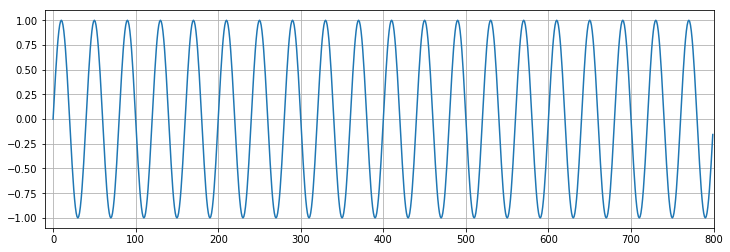

In [17]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy())

In [18]:
test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

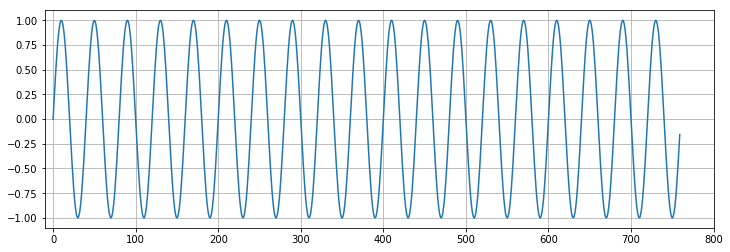

In [20]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(train_set.numpy())

In [22]:
def input_data(seq,ws):
    
    out = []  # ([0,1,2,3],[4]) , ([1,2,3,4],[5])
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    
    
    
    return out

In [23]:
window_size = 40

train_data = input_data(train_set,window_size)

In [24]:
len(train_data)

720

In [26]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [27]:
train_data[1]

(tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
          8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
          9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
          5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
         -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01,
         -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01, -1.0000e+00,
         -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01, -7.0710e-01,
         -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,  1.4480e-05]),
 tensor([0.1564]))

In [28]:
# RNN - Creating LSTM modeling within

class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=50,out_size=1):
        
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        self.linear = nn.Linear(hidden_size,out_size)
        
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
        
    def forward(self,seq):
        
        lstm_out , self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        
        pred = self.linear(lstm_out.view(len(seq),-1))
        
        return pred[-1]   # we only care about the last prediction

In [29]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

In [30]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [31]:
for p in model.parameters():
    print(p.numel())

200
10000
200
200
50
1


Epoch 0 Loss: 0.09212874621152878
Performance on test range: 0.6071590185165405


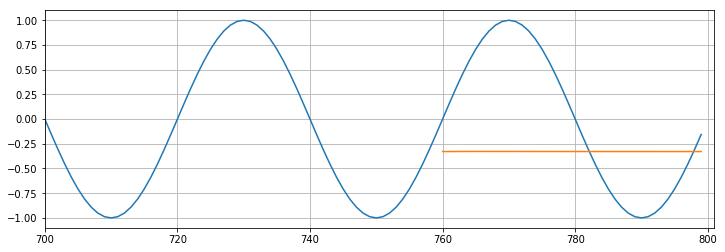

Epoch 1 Loss: 0.06506767123937607
Performance on test range: 0.565098762512207


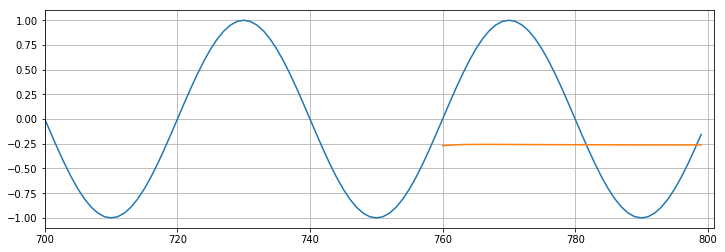

Epoch 2 Loss: 0.04198046773672104
Performance on test range: 0.5199716687202454


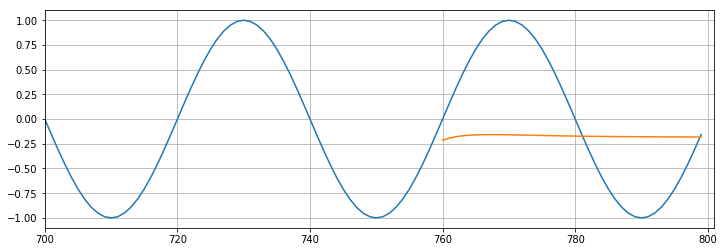

Epoch 3 Loss: 0.01784275658428669
Performance on test range: 0.42209967970848083


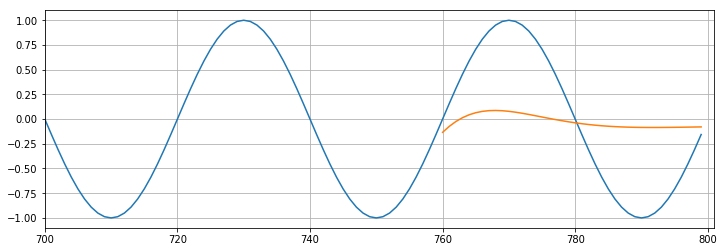

Epoch 4 Loss: 0.0028870997484773397
Performance on test range: 0.16624116897583008


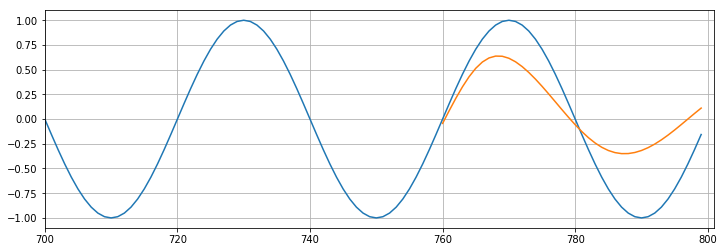

Epoch 5 Loss: 0.0003200757782906294
Performance on test range: 0.03055439703166485


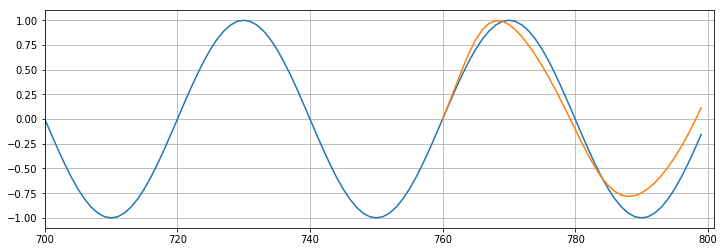

Epoch 6 Loss: 0.00012969104864168912
Performance on test range: 0.014990181662142277


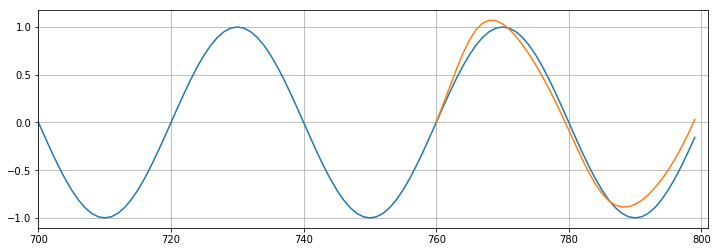

Epoch 7 Loss: 0.00012006733595626429
Performance on test range: 0.011856676079332829


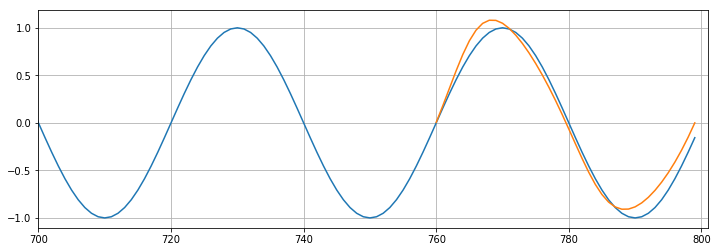

Epoch 8 Loss: 0.0001265565661014989
Performance on test range: 0.010163827799260616


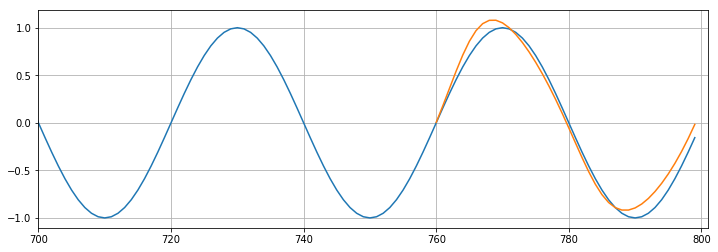

Epoch 9 Loss: 0.00013195407518651336
Performance on test range: 0.00889757089316845


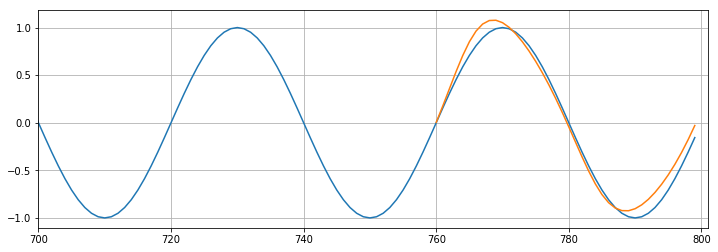

In [33]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq,y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    
    for f in range(future):
        
        seq = torch.FloatTensor(preds[-window_size:])
        
        with torch.no_grad():
            
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Performance on test range: {loss}')
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

In [34]:
epochs = 15
window_size = 40
future = 40

all_data = input_data(y,window_size)
len(all_data)

760

In [36]:
import time
start_time = time.time()

for i in range(epochs):
    
    for seq,y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    
total_time = time.time() - start_time
print(total_time/60)

Epoch 0 Loss: 0.0001380172761855647
Epoch 1 Loss: 0.00013590336311608553
Epoch 2 Loss: 0.00013306352775543928
Epoch 3 Loss: 0.00012923598114866763
Epoch 4 Loss: 0.0001246960018761456
Epoch 5 Loss: 0.00011971588537562639
Epoch 6 Loss: 0.00011450950114522129
Epoch 7 Loss: 0.00010923500667558983
Epoch 8 Loss: 0.00010400583414593711
Epoch 9 Loss: 9.890312503557652e-05
Epoch 10 Loss: 9.397701069246978e-05
Epoch 11 Loss: 8.926257578423247e-05
Epoch 12 Loss: 8.478001109324396e-05
Epoch 13 Loss: 8.05361705715768e-05
Epoch 14 Loss: 7.65331496950239e-05
2.996773672103882


## Forecast into the unknown future

In [37]:
preds = y[-window_size:].tolist()

for i in range(future):
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():

        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())

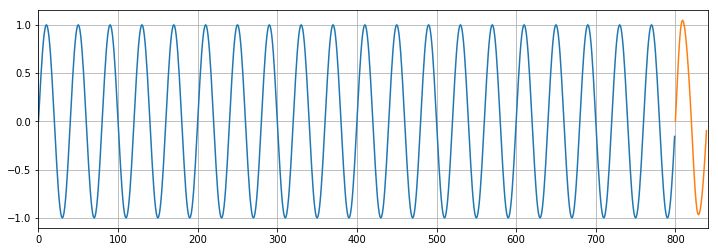

In [38]:
plt.figure(figsize=(12,4))
plt.xlim(0,841)
plt.grid(True)
plt.plot(y.numpy())

# Plotting Forecast
plt.plot(range(800,800+future),preds[window_size:])
plt.show()